In [3]:
import os
import time
import sys
from datetime import datetime
sys.path.append("/global/homes/s/seanjx/gigalens/src")

from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import epl, shear, sie, sis

import tensorflow_probability.substrates.jax as tfp

import jax
from jax import random
from jax import numpy as jnp

import numpy as np
import optax
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.visualization import simple_norm

tfd = tfp.distributions

/global/common/software/deepsrch/jax_gigalens_kernel/jax-gigalens/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def printToFile(thing, path):
    outputfile = open(path, 'w')
    print(thing,file=outputfile)
    outputfile.close()

In [5]:
now = str(datetime.now())

now = "2024-06-20 12:03:01.477412"
path = "output/"+now
outputPath = path+"output.txt"
#os.makedirs(path)

printToFile(now+"\n",outputPath)
printToFile(str(jax.devices())+"\n",outputPath)

In [10]:
f=fits.open('psf1.fits') 
psf=f[0].data

observed_img = np.load("cutout.npy")

background_rms=0.0075455
exp_time=1197

err_map = np.sqrt(background_rms**2 + observed_img/exp_time)
threshold_lens=1.
error_masked=err_map
error_masked[45:65,45:65]=np.where(observed_img[45:65,45:65]>threshold_lens, 120000, error_masked[45:65,45:65]) #mask the lens
error_masked[5:15,75:85]=np.where(observed_img[5:15,75:85]>0.3, 120000, error_masked[5:15,75:85])

In [8]:
phys_model = PhysicalModel([sie.SIE(),shear.Shear()], [sersic.SersicEllipse(use_lstsq=True),sersic.SersicEllipse(use_lstsq=True),sersic.SersicEllipse(use_lstsq=True)], [sersic.SersicEllipse(use_lstsq=True),])

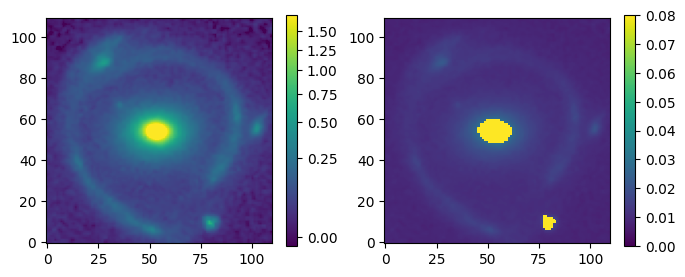

In [11]:
plt.figure(figsize=(8,3))
plt.subplot(121)

norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

plt.subplot(122)
plt.imshow(err_map, vmin=0,vmax=0.08, origin='lower')
plt.colorbar()

In [4]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(2.8), 0.1),
                # gamma=tfd.TruncatedNormal(2, 0.5, 1, 3),
                e1=tfd.Normal(0.13, 0.1),
                e2=tfd.Normal(-0.03, 0.1),
                center_x=tfd.Normal(-0.3, 0.1),
                center_y=tfd.Normal(0.1, 0.1),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(-0.03, 0.1), gamma2=tfd.Normal(-0.07, 0.1))
        ),
        
        
        # tfd.JointDistributionNamed(
        #     dict(
        #         theta_E=tfd.LogNormal(jnp.log(0.5), 0.25),
        #         # gamma=tfd.TruncatedNormal(2, 0.5, 1, 3),
        #         e1=tfd.Normal(0, 0.1),
        #         e2=tfd.Normal(0, 0.1),
        #         center_x=tfd.Normal(1.6, 0.1),
        #         center_y=tfd.Normal(-3, 0.1),
        #     )
        # ),
        # tfd.JointDistributionNamed(
        #     dict(
        #         theta_E=tfd.LogNormal(jnp.log(0.5), 0.25),
        #         # gamma=tfd.TruncatedNormal(2, 0.5, 1, 3),
        #         e1=tfd.Normal(0, 0.1),
        #         e2=tfd.Normal(0, 0.1),
        #         center_x=tfd.Normal(3, 0.1),
        #         center_y=tfd.Normal(0, 0.1),
        #     )
        # ),
        # tfd.JointDistributionNamed(
        #     dict(
        #         theta_E=tfd.LogNormal(jnp.log(0.5), 0.25),
        #         # gamma=tfd.TruncatedNormal(2, 0.5, 1, 3),
        #         e1=tfd.Normal(0, 0.1),
        #         e2=tfd.Normal(0, 0.1),
        #         center_x=tfd.Normal(-2, 0.1),
        #         center_y=tfd.Normal(2, 0.1),
        #     )
        # ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.1),
                n_sersic=tfd.Uniform(4,10),
                e1=tfd.TruncatedNormal(0.3, 0.05, -0.3, 0.3),
                e2=tfd.TruncatedNormal(-0.08, 0.05, -0.3, 0.3),
                center_x=tfd.Normal(-0.02, 0.05),
                center_y=tfd.Normal(-0.08, 0.05),
                # Ie=tfd.LogNormal(jnp.log(262.0), 0.15),
            )
        ),
        # tfd.JointDistributionNamed(
        #     dict(
        #         R_sersic=tfd.LogNormal(jnp.log(0.25), 0.1),
        #         n_sersic=tfd.Uniform(1,4),
        #         e1=tfd.TruncatedNormal(0.3, 0.05, -0.3, 0.3),
        #         e2=tfd.TruncatedNormal(-0.08, 0.05, -0.3, 0.3),
        #         center_x=tfd.Normal(-0.02, 0.05),
        #         center_y=tfd.Normal(-0.08, 0.05),
        #         Ie=tfd.LogNormal(jnp.log(262.0), 0.15),
        #     )
        # ),
        
        # tfd.JointDistributionNamed(
        #     dict(
        #         R_sersic=tfd.LogNormal(jnp.log(0.1), 0.1),
        #         n_sersic=tfd.Uniform(1,10),
        #         e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
        #         e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
        #         center_x=tfd.Normal(1.6, 0.1),
        #         center_y=tfd.Normal(-3, 0.1),
        #         # Ie=tfd.LogNormal(jnp.log(100), 0.15),
        #     )
        # ),
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.1), 0.1),
                n_sersic=tfd.Uniform(1,10),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(3, 0.1),
                center_y=tfd.Normal(0, 0.1),
                # Ie=tfd.LogNormal(jnp.log(100), 0.15),
            )
        ),
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.1), 0.1),
                n_sersic=tfd.Uniform(1,10),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(-2, 0.1),
                center_y=tfd.Normal(2, 0.1),
                # Ie=tfd.LogNormal(jnp.log(100), 0.15),
            )
        ),
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.15), 0.25),
                n_sersic=tfd.Uniform(1, 10),
                e1=tfd.TruncatedNormal(0, 0.25, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.25, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                # Ie=tfd.LogNormal(jnp.log(100.0), 0.25),
            ),
        ),
        # tfd.JointDistributionNamed(
        #     dict(
        #         R_sersic=tfd.LogNormal(jnp.log(0.15), 0.25),
        #         n_sersic=tfd.Uniform(1, 10),
        #         e1=tfd.TruncatedNormal(0, 0.25, -0.5, 0.5),
        #         e2=tfd.TruncatedNormal(0, 0.25, -0.5, 0.5),
        #         center_x=tfd.Normal(0, 0.25),
        #         center_y=tfd.Normal(0, 0.25),
        #         Ie=tfd.LogNormal(jnp.log(100.0), 0.25),
        #     )
        # ),
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [5]:
prior

<tfp.distributions.JointDistributionSequential 'JointDistributionSequential' batch_shape=[[{center_x: [], center_y: [], e1: [], e2: [], theta_E: []}, {gamma1: [], gamma2: []}], [{R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}, {R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}, {R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}], [{R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}]] event_shape=[[{center_x: [], center_y: [], e1: [], e2: [], theta_E: []}, {gamma1: [], gamma2: []}], [{R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}, {R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}, {R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}], [{R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}]] dtype=[[{center_x: float32, center_y: float32, e1: float32, e2: float32, theta_E: float32}, {gamma1: float32, gamma2: float

In [3]:
import json
print(json.dumps(prior))

TypeError: Object of type JointDistributionSequential is not JSON serializable

In [15]:
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=np.shape(observed_img)[0], supersample=2, kernel=psf)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

prob_model = BackwardProbModel(prior, observed_img, error_masked, background_rms=0.0075455	, exp_time=1197)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [15]:
start = time.perf_counter()
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-4, 
                                      power=0.5, transition_steps=500)

opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)

#n_samples_bs = 1000

map_estimate, chi = model_seq.MAP(opt, n_samples=5000,num_steps=500,seed=0)
end = time.perf_counter()


  0%|          | 0/500 [01:05<?, ?it/s]


KeyboardInterrupt: 

In [16]:
path="output/"+now
np.save(path+"/map.npy",map_estimate)
printToFile("MAP took "+str(end-start)+" seconds \n",outputPath)

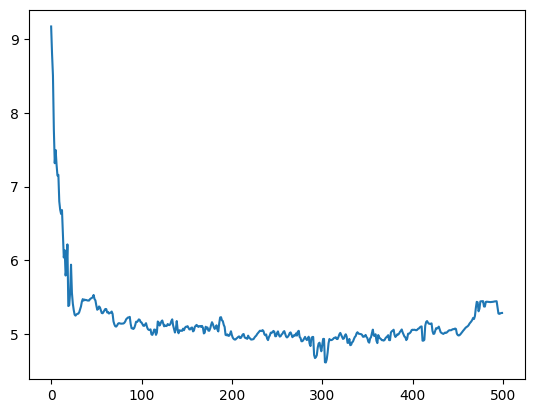

In [17]:
plt.plot(np.array(chi))
plt.savefig(path+"/chi-squared.png")

In [ ]:
start = time.perf_counter()
map_estimate=np.load(path+"/map.npy")

lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=5000), map_estimate)[0]
best = map_estimate[jnp.nanargmax(lps)][jnp.newaxis,:]

end = time.perf_counter()
print("log_prob took "+str(end-start)+" seconds \n",file=outputfile)
np.save(path+"/best.npy",best)

In [ ]:
params = prob_model.bij.forward(best.tolist()[0])

for i in range(0,len(params[0])):
    print("lens:", [[ii,float(params[0][i][ii])] for ii in params[0][i]], "\n",file=outputfile)

for i in range(0,len(params[1])):
    print("lens light:", [[ii,float(params[1][i][ii])] for ii in params[1][i]], "\n",file=outputfile)

for i in range(0,len(params[2])):
    print("source light:", [[ii,float(params[2][i][ii])] for ii in params[2][i]], "\n",file=outputfile)

plt.figure(figsize=(10, 3))

plt.subplot(131)
norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

simulated = lens_sim.lstsq_simulate(params,jnp.array(observed_img),err_map)

plt.subplot(132)
plt.imshow(simulated, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.subplot(133)
resid = jnp.array(observed_img) - simulated
background_rms, exp_time = 0.0075455, 1197
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-1, vmax=1)

print('Chi-square:', np.mean((resid/err_map)**2), "\n",file=outputfile)
plt.axis('off')
plt.colorbar()

plt.savefig(path+"/output.png")
outputfile.close()
print("done")

In [22]:
mask_obs_img = np.where(error_masked>1, 0, 1)
dof = len(np.where(mask_obs_img.reshape(-1))[0]) - 30
print(dof)

residual=jnp.array(observed_img)-simulated
resid = residual/error_masked
resid_mask = resid*mask_obs_img
red_chi_sq = np.sum(resid_mask.reshape(-1)**2)/dof #Sum over the pixels where the image is not masked
print(red_chi_sq)

11930
5.757095


In [ ]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best, opt, n_vi=500, num_steps=1000)

ELBO: 68226.484:  27%|██▋       | 273/1000 [02:12<05:31,  2.19it/s]

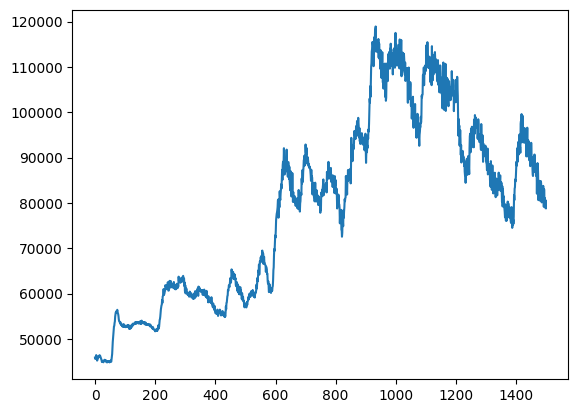

In [10]:
plt.plot(loss_hist)

In [ ]:
samples = model_seq.HMC(qz, num_burnin_steps=250, num_results=750)

In [ ]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)
print(rhat)

In [ ]:
import tensorflow
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['gamma'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[0][1]['gamma1'],
    x[0][1]['gamma2'],
])
physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()
markers = get_samples(truth)
corner(physical_samples.reshape((8,-1)).T, truths=markers, 
       show_titles=True, title_fmt='.3f',
       labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x$', r'$y$', r'$\gamma_{1,ext}$', r'$\gamma_{2,ext}$']);

In [ ]:
params = prob_model.bij.forward(samples)

print("lens:", [[ii,float(params[0][0][ii])] for ii in params[0][0]], "\n")
print("lens external:", [[ii,float(params[0][1][ii])] for ii in params[0][1]], "\n")
print("lens light:", [[ii,float(params[1][0][ii])] for ii in params[1][0]], "\n")
print("source light:", [[ii,float(params[2][0][ii])] for ii in params[2][0]], "\n")


plt.figure(figsize=(10, 3))

plt.subplot(131)
norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

plt.subplot(132)
#norm = simple_norm(lens_sim.simulate(params), 'sqrt', percent=99.)
plt.imshow(lens_sim.simulate(params), norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.subplot(133)
simulated = lens_sim.simulate(params)
resid = simulated - jnp.array(observed_img)
background_rms, exp_time = 0.0075455, 1197
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-1, vmax=1)

print('Chi-square:', np.mean((resid/err_map)**2))
plt.axis('off')
plt.colorbar()

